In [9]:
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.graph_objs import *
import plotly.express as px

import seaborn as sns
import os
import glob
import string

import numpy as np
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from numpy import linalg as LA
from sklearn.metrics import pairwise_distances_argmin_min
import hdbscan
from scipy.cluster.hierarchy import fcluster
from sklearn import preprocessing
from sklearn.cluster import KMeans
import umap

import warnings
warnings.filterwarnings("ignore")

In [18]:
# Cluster based on COVD
def cluster_nuclei_intensity(filename,df,n_neighbors,threshold_q,auto_open,plot_switch):
    embedding = df[['xi','yi','zi']].to_numpy()   
    '''
    Calculate the local curvature of the point cloud embedding
    '''
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(embedding)
    distances, indices = nbrs.kneighbors(embedding)
    eigvals = [LA.eigvalsh(np.cov(embedding[indices[idx,:],:].T)) for idx in range(embedding.shape[0])] #full data
    curvatures = [min(eigvals[idx])/sum(eigvals[idx]) for idx in range(len(eigvals))]
    # Add curvature to the dataframe
    df['curvature'] = curvatures 
    # Find the minima in curvature histrogram
    q1 = np.quantile(curvatures,threshold_q)
    df1 = df[df['curvature'] <= q1] # define the low curvature sector
    min_cluster_size = int(df1.shape[0]/15)     # hyperparameter
    min_samples = int(min_cluster_size/15)       # hyperparameter

    clusterer = hdbscan.HDBSCAN(min_samples=min_samples,min_cluster_size=min_cluster_size,gen_min_span_tree=True)
    clusterer.fit(df1.loc[:,('xi','yi','zi')]) 
    clusterer.condensed_tree_.plot(select_clusters=True,
                                   selection_palette=sns.color_palette("Set2",len(clusterer.labels_)))
    plt.show()
    plt.savefig(filename+'.tree.intensity.png')
    plt.close()
    
    df1['clusterID1'] = clusterer.labels_    # add cluster id to dataframe
    df1['clusterID1'] = df1['clusterID1'].apply(str)   # make cluster id a string
    df1_filtered = df1[df1.clusterID1 != str(-1)] # remove unassigned points

    # expand the clusters to the entire point-cloud
    idx, dist = pairwise_distances_argmin_min(df[['xi','yi','zi']].to_numpy(),df1_filtered[['xi','yi','zi']].to_numpy())
    #add 1 to avoid confusion with background
    df['clusterID1'] = [int(df1_filtered.clusterID1.iloc[idx[row]])+1 for row in range(df.shape[0])] 
    df['clusterID1'] = df['clusterID1'].apply(str)
    # plot the spatial projetion    
    if plot_switch:
        scattered_wsi(df,"cx","cy","clusterID1",2,0.5,auto_open,filename)
    return df

# Plot WSI with colored labels
def scattered_wsi(df,x,y,hue,size,opacity,auto_open,filename):
    fig = px.scatter(df,
                     x=x, y=y,color=hue,
                     width=800, height=800,
                     color_discrete_sequence=px.colors.qualitative.Set2)
    fig.update_traces(marker=dict(size=size,opacity=opacity))
    fig.update_layout(template='simple_white')
    fig.update_layout(legend= {'itemsizing': 'constant'})
    fig.write_html(filename+'.spatial_projection.html', auto_open=auto_open)
    return 

# Define a pairing function to label uniquely pairs of morpho and intensity clusters
def cantor(n,m):
    return 0.5*(n+m)*(n+m+1)+m
#######################################################

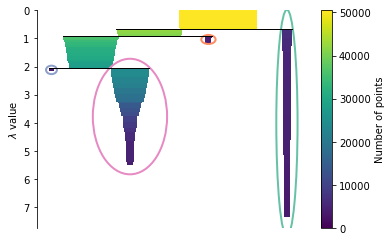

In [8]:
sample_size = -100000 # set to 0 if the entire sample is considered
n_neighbors = 100   # hyperparameter. NNN in the curvature calculation
threshold_q = 0.1   # hyperparameter. The quantile defining the low-curvature sector
auto_open = False    # switch to open or not html figures in new tab
plot_switch = False  # switch to generate or not html figures

filename = '../data_intensity/pkl/id_13.measurements.covd.pkl' # pkl file
df = pd.read_pickle(filename)
if sample_size > 0 and sample_size < df.shape[0]:
    df = df.sample(n=sample_size)
df = cluster_nuclei_intensity(filename,
                              df,
                              n_neighbors=n_neighbors,
                              threshold_q=threshold_q,
                              auto_open=auto_open,
                              plot_switch=plot_switch)

In [1]:
# rescale morphological features to 0-1 range
features =  ['area', 'perimeter', 'solidity', 'eccentricity','circularity',
             'mean_intensity', 'std_intensity', 'cov_intensity']
for feature in features:
    f = df[feature].as_matrix().reshape(-1,1) #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    f_scaled = min_max_scaler.fit_transform(f)
    df[feature] = f_scaled

# select the list of morphological features to be clustered 
features2cluster = ['area',
                    #'perimeter', 
                    #'solidity',
                    'eccentricity', 
                    'circularity', 
                    #'mean_intensity', 
                    'cov_intensity'
                   ]
df["clusterID2"] = -1 # initialize the morphological cluster id
for c_id in set(df.clusterID1): # for each cluster1 id
    # reduced morphological representation with umap
    fdf = df[df["clusterID1"] == c_id][features2cluster] # filter wrt features
    embedding_morphology = umap.UMAP(min_dist=0.0,
                                     n_components=3,
                                     random_state=42).fit_transform(fdf)
    # create dataframes of the umap morphological embedding                                                                                                                                                                          
    df_embedding_morphology = pd.DataFrame(data=embedding_morphology, 
                                           columns=['xm','ym','zm'],
                                           index=fdf.index)
    fdf = pd.concat([fdf,df_embedding_morphology],axis=1) # update fdf with embedding
    # cluster umap representation of morphology with HDBSCAN
    min_cluster_size = int(fdf.shape[0]/20)       # hyperparameter
    min_samples = int(min_cluster_size/15)         # hyperparameter
    clusterer = hdbscan.HDBSCAN(min_samples=min_samples,
                                metric='minkowski', p=2,
                                min_cluster_size=min_cluster_size,
                                gen_min_span_tree=True)
    clusterer.fit( fdf[['xm','ym','zm']] )
    df.loc[df.clusterID1 == c_id, "clusterID2"] = clusterer.labels_     #update dataframe

# Filter out unlabeled morphological clusters
df_labeled = df[df["clusterID2"] != -1] 
# Use cantor mapping to combine the covd cluster id with the morphology cluster id uniquely
df_labeled["clusterID12"] = cantor(df_labeled["clusterID1"].apply(int),df_labeled["clusterID2"].apply(int) ) 
#define a dictionary to rewrite the paired labels in a continuous numeric way
dic = {}
labels = set(df_labeled["clusterID12"])
for counter, value in enumerate(list(labels)):
    dic[value] = counter # map cluster ID12 to an integer

# Define the dataframe of labeled covd+morphology clusters    
df_labeled['clusterID3'] = df_labeled['clusterID12'].map(dic)

# Characterize the profile of clusterID3 by the mean of morpho features
# profile features can be the same as features2cluster or different
profile_features = features2cluster
profiles = np.zeros((len(set(df_labeled["clusterID3"])), #row_numb=numb of clusters
                     len(profile_features)               #col_numb=numb of features
                    ))
row = 0
list_clusterID3 = list(set(df_labeled["clusterID3"])) 
for c in list_clusterID3:  # for each cluster
    dfc = df_labeled[df_labeled["clusterID3"] == c][profile_features] # filter wrt to features
    profiles[row,:] = dfc.mean().values  # get the mean of the features
    row += 1

# Cluster the profiles with kmeans
kmeans = KMeans(n_clusters=4, random_state=0).fit(profiles)

# map clusterID3 to kmeans labels
dic = {}
for x, y in zip(list_clusterID3, kmeans.labels_):
    dic[x]=y 
df_labeled['clusterID4'] = df_labeled.clusterID3.map(dic)

if 'clusterID12' in df_labeled.columns:
    df_labeled.drop(columns=['clusterID12'],inplace=True)   # drop redundant columns
if 'clusterID3' in df_labeled:
    df_labeled.drop(columns=['clusterID3'],inplace=True)   # drop redundant columns
df_labeled.rename(columns={"clusterID4": "clusterID3"},inplace=True) # rename columns
df_labeled['clusterID3'] = df_labeled['clusterID3'].apply(str)

new_df = pd.concat([df,df_labeled],axis=1) # concatenate full and morpho-labeled dataframes
new_df = new_df.loc[:,~new_df.columns.duplicated()] # remove duplicate columns

'''
Expand the clusters to the entire point-cloud
'''
#aggregate around morphological profile features
#find the idx that minimizes the dist to the given labeled nucleus cluster ID3
idx, dist = pairwise_distances_argmin_min(new_df[features2cluster].to_numpy(),df_labeled[features2cluster].to_numpy())
new_df['clusterID3'] = [int(df_labeled.clusterID3.iloc[idx[row]]) for row in range(new_df.shape[0])] 
new_df['clusterID3'] = new_df['clusterID3'].apply(str)
# save to disk
new_df.to_csv(filename+'.intensityANDmorphology.csv.gz',index=False)

NameError: name 'pd' is not defined

In [24]:
df = pd.read_csv('../data_intensity/pkl/id_17.measurements.covd.pkl.intensityANDmorphology.csv.gz')

In [25]:
# Plot the morphology profiles by clusterID3
features2cluster = ['area',
                    #'perimeter', 
                    #'solidity',
                    'eccentricity', 
                    'circularity', 
                    'mean_intensity', 
                    'cov_intensity'
                   ]
dfmelted = pd.DataFrame()
for c in set(df["clusterID3"]):
    dfc = df[df["clusterID3"] == c][features2cluster]
    data = pd.melt(dfc)
    data['ID'] = 'id_'+str(c)
    dfmelted = dfmelted.append(data)

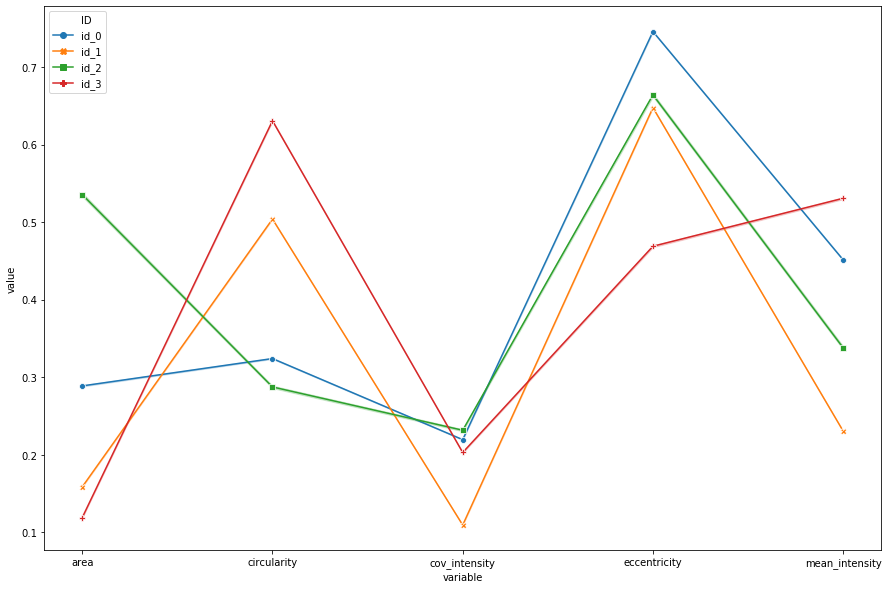

In [26]:
plt.figure(figsize=(15,10))
sns.lineplot(x="variable", y="value",hue='ID',style='ID',
             #err_style = 'bars',
             data=dfmelted, 
             #ci='sd',
             legend='full',
             markers=True, 
             dashes=False)
plt.legend(loc='upper left')
plt.show()

In [27]:
df['clusterID3'].value_counts()

1    606162
0    208864
3     95306
2     32591
Name: clusterID3, dtype: int64

In [30]:
df['ID'] = df.apply(lambda row: 'id_'+str(int(row.clusterID3)), axis=1)

scattered_wsi(df,'cx','cy','ID',3,1,True,'test')